In [ ]:
import torch
import torchvision
import os
import numpy as np
import random
import timeit
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from diffusers import DDIMScheduler, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from utils import CustomImageLabelDataset, mean_std, split_dataset, label_normalizer
from unet import ConditionalUNet

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f'The device is {device}.')

# Path for saving loss img and model parameters
save_dir = 'model'
os.makedirs(save_dir, exist_ok=True)
model_name = '0506_model_rf'
cht_path = os.path.join(save_dir, f'{model_name}.png')
mdl_path = os.path.join(save_dir, f'{model_name}.pth')

RANDOM_SEED = 0
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 50
NUM_TIMESTEPS = 1000
NUM_WARMUP_STEPS = 500
PATIENCE = 10

max_power = 200.
min_power = 100.
max_scan_speed = 1.0
min_scan_speed = 0.5

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The device is mps.


Preparing dataloder...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9379619..1.1625445].


mean and std of the dataset are: ([0.7038602828979492, 0.585344672203064, 0.6048067808151245], [0.32879573106765747, 0.36584195494651794, 0.33993813395500183])
Train dataset size: 16000
Validation dataset size: 4000
Input shape: torch.Size([16, 3, 128, 128])
Labels: tensor([[175.0000,   0.8000],
        [165.0000,   0.7500],
        [135.0000,   0.7500],
        [120.0000,   0.5000],
        [135.0000,   0.7500],
        [175.0000,   1.0000],
        [175.0000,   0.6000],
        [175.0000,   0.6000],
        [185.0000,   0.8000],
        [160.0000,   0.5500],
        [115.0000,   0.7000],
        [165.0000,   0.7500],
        [190.0000,   0.9000],
        [115.0000,   0.7000],
        [150.0000,   0.5000],
        [125.0000,   0.8000]])


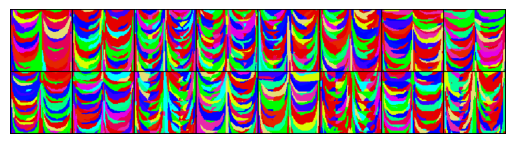

In [3]:
print('Preparing dataloder...')

# local path
image_folder = '/Users/xiezy/Documents/ml/diffusion/data/cross_sec/train_simu/train/images'
label_folder = '/Users/xiezy/Documents/ml/diffusion/data/cross_sec/train_simu/train/labels'

# path on the cloud
# image_folder = '/bohr/rf2-wtvk/v4/train_rf/images'
# label_folder = '/bohr/rf2-wtvk/v4/train_rf/labels'

transform0 = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST), 
    transforms.ToTensor()  # rescale: from 0-255 to 0-1
])
dataset = CustomImageLabelDataset(image_folder=image_folder, label_folder=label_folder, transform=transform0)
mean, std = mean_std(dataset)
print(f'mean and std of the dataset are: {mean, std}')

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)  # normalize by the mean and std 
])

dataset = CustomImageLabelDataset(image_folder=image_folder, label_folder=label_folder, transform=transform)

dataset_size = len(dataset)
train_indices, val_indices = split_dataset(dataset_size, val_ratio=0.2)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
grid_img = torchvision.utils.make_grid(x)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()


In [4]:
model = ConditionalUNet()
model.to(device)

noise_scheduler = DDIMScheduler(num_train_timesteps=NUM_TIMESTEPS)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE) 

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=len(train_dataloader) * NUM_EPOCHS
)

early_stopping_patience = PATIENCE
best_val_loss = float('inf') 
patience_counter = 0

In [ ]:
losses = []
val_losses = []

start = timeit.default_timer()
print(f'Everything is ready.\nTraining start time: {start:.2f}s')

for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    # traning
    model.train()
    train_running_loss = 0
    for x, y in train_dataloader:
        clean_images = x.to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        power, scan_speed = y[:, 0], y[:, 1]
        power = label_normalizer(power, max_power, min_power).to(device)
        scan_speed = label_normalizer(scan_speed, max_scan_speed, min_scan_speed).to(device)

        noise_pred = model(noisy_images, timesteps, power, scan_speed)
        loss = F.mse_loss(noise_pred, noise)
        train_running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
    
    avg_train_loss = train_running_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    train_learning_rate = lr_scheduler.get_last_lr()[0]

    # validation
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for x, y in val_dataloader:
            clean_images = x.to(device)
            noise = torch.randn(clean_images.shape).to(device)
            last_batch_size = len(clean_images)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            power, scan_speed = y[:, 0], y[:, 1]
            power = label_normalizer(power, max_power, min_power).to(device)
            scan_speed = label_normalizer(scan_speed, max_scan_speed, min_scan_speed).to(device)

            noise_pred = model(noisy_images, timesteps, power, scan_speed)
            val_loss = F.mse_loss(noise_pred, noise)
            val_running_loss += val_loss.item()
    
    avg_val_loss = val_running_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print('-' * 50)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f'Train Learning Rate: {epoch + 1}: {train_learning_rate}')
    print(f"Training Loss: {avg_train_loss:.6f}")
    print(f"Validation Loss: {avg_val_loss:.6f}")
    print('-' * 50)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), mdl_path)
        print("Best model saved.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve for {patience_counter} epoch(s).")
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

end = timeit.default_timer()
print(f'Training finish time: {end:.2f}s')
print(f'Total training time: {end - start:.2f}s')

plt.figure()
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(cht_path) 
plt.close()
print(f"Loss chart saved.")

# EVA

In [5]:
model = ConditionalUNet()

file_dir = '/Users/xiezy/Documents/ml/diffusion/model_save'
file_name = 'c_trans.pth'
os.makedirs(file_dir, exist_ok=True)
file_path = os.path.join(file_dir, file_name)

model.load_state_dict(torch.load(file_path, map_location=torch.device(device)))

model.eval()

model.to(device)

# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)

/var/folders/dm/jlzk2q5d6xb7hnxbrd5rz7800000gp/T/ipykernel_37870/3931939643.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, m

tensor([0.5000], device='mps:0') tensor([0.], device='mps:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])
tensor([0.1057, 0.1133, 0.1148])
tensor([0.6488, 0.6507, 0.5582])
tensor(1.)


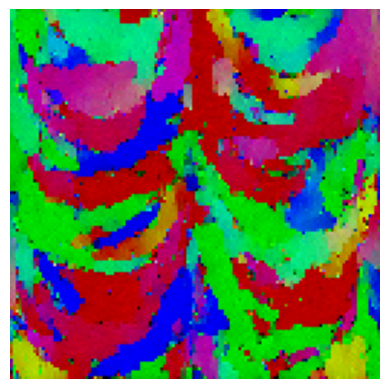

In [ ]:
# generate random noise
# torch.manual_seed(42)
# noise_scheduler.set_timesteps(num_inference_steps=20)

num_images = 1

x = torch.randn(num_images, 3, 128, 128).to(device)

power = torch.full((num_images, ), 150.)
scan_speed = torch.full((num_images, ), 0.5)
power = label_normalizer(power, max_power, min_power).to(device)
scan_speed = label_normalizer(scan_speed, max_scan_speed, min_scan_speed).to(device)
print(power, scan_speed)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(x, t, power, scan_speed)

    x = noise_scheduler.step(residual, t, x).prev_sample

for i, t in enumerate(noise_scheduler.timesteps[-1:]):
    with torch.no_grad():
        residual = model(x, t, power, scan_speed)

    x = noise_scheduler.step(residual, t, x).prev_sample

x = x.detach().cpu()
print(type(x))
print(x.shape)
print(x.mean(dim=(0, 2, 3)))
print(x.std(dim=(0, 2, 3)))
print(torch.max(x))

grid_img = torchvision.utils.make_grid(x)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21950272..1.0310011].


torch.Size([1, 3, 128, 128])
mean: tensor([0.7386, 0.6268, 0.6438])
std: tensor([0.2133, 0.2381, 0.1898])
max: 1.031001091003418
min: 0.21950271725654602


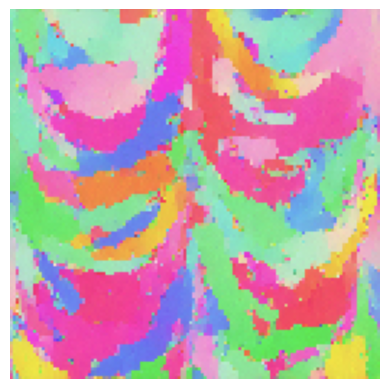

In [72]:
def img_denormalizer(batch, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)  
    denormalized_batch = batch * std + mean

    return denormalized_batch


denormalized_batch = img_denormalizer(x, mean, std)
print(denormalized_batch.shape)
print(f"mean: {denormalized_batch.mean(dim=(0, 2, 3))}\n"
      f"std: {denormalized_batch.std(dim=(0, 2, 3))}\n"
      f"max: {denormalized_batch.max()}\n"
      f"min: {denormalized_batch.min()}")

grid_img = torchvision.utils.make_grid(denormalized_batch)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')

plt.savefig('../data/cross_sec/gen_images/tune/tune15-2.jpg', bbox_inches='tight', pad_inches=0, dpi=300)

# sample_img_1 = denormalized_batch.clamp(0, 1)
# sample_img_255 = (sample_img_1 * 255).byte().permute(0, 2, 3, 1)

# print(sample_img_255.shape)

# resize_transform = transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST)

# resized_imgs = []
# for i in range(sample_img_255.shape[0]):
#     pil_img = Image.fromarray(np.array(sample_img_255[i]))
#     resized_img = resize_transform(pil_img)
#     resized_imgs.append(resized_img)

# resized_imgs_np = np.array(resized_imgs)
# print(resized_imgs_np.shape)

# batch_size = resized_imgs_np.shape[0]
# ncols = 1
# nrows = (batch_size + ncols - 1) // ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))

# if nrows == 1 or ncols == 1:
#     axes = np.array(axes).reshape(nrows, ncols)

# for i in range(batch_size):
#     ax = axes[i // ncols, i % ncols]
#     ax.imshow(resized_imgs_np[i])
#     ax.axis('off')

# for j in range(batch_size, nrows * ncols):
#     axes[j // ncols, j % ncols].axis('off')

# plt.tight_layout()
# plt.show()